In [45]:
from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd

In [95]:
def data_loader(path):
    table = pd.read_csv(path, index_col=[0])
    return table

In [96]:
df = data_loader('./data/laptops.csv')

In [97]:
def slice_df(table, col_name):
    test_df = table[table[col_name].isnull() == True]
    train_df = table[table[col_name].isnull() == False]
    return test_df, train_df

In [98]:
test_df, train_df = slice_df(df, 'rating')

- test_df : nan값이 있는 데이터, 최종 predict y를 넣어주어야 하는 데이터
- train_df : nan값이 없는 데이터, 학습 및 성능 확인이 되어야 하는 데이터

In [99]:
def slice_columns(*col_names):
    list = []
    for col in col_names:
        list.append(col)
    return list

In [100]:
sparse_col = slice_columns('img_link', 'name', 'processor', 'ram', 'os', 'storage')
dense_col = slice_columns('price(in Rs.)', 'display(in inch)')

- sparse_col : categorical columns
- dense_col : countable columns

In [101]:
def scaler_encoder(sparese, dense, target_df):
    target_df = target_df.copy()
    mms = MinMaxScaler(feature_range=(0, 1))
    target_df[dense] = mms.fit_transform(target_df[dense])
    for feat in sparese:
        lbe = LabelEncoder()
        target_df[feat] = lbe.fit_transform(target_df[feat])
    return target_df

In [102]:
train_df_transform = scaler_encoder(sparse_col, dense_col, train_df)
test_df_transform = scaler_encoder(sparse_col, dense_col, test_df)

In [103]:
train_df_transform

,img_link,name,price(in Rs.),processor,ram,os,storage,display(in inch),rating,no_of_ratings,no_of_reviews
0,292,271,0.142684,26,1,10,12,0.170940,4.5,14.0,1.0
1,320,277,0.065301,22,15,4,2,0.170940,4.4,53.0,3.0
2,242,56,0.103218,25,15,10,12,0.170940,4.4,4733.0,463.0
3,322,72,0.054645,21,15,4,12,0.170940,4.3,10406.0,1040.0
4,328,234,0.009107,1,11,7,10,0.102564,3.8,18.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
978,100,11,0.018215,18,12,6,12,0.102564,3.8,1135.0,167.0
979,89,73,0.066788,21,15,3,0,0.170940,4.0,1907.0,227.0
980,104,187,0.020279,45,13,6,0,0.000000,3.8,5991.0,687.0
981,300,42,0.118397,6,15,10,12,0.102564,4.5,22.0,5.0


- train_df_transform : train, 선학습 될 데이터의 전처리
- test_df_transform : test, 후학습 될 데이터의 전처리

In [104]:
def fixlen_feature(target_df, slice_sparse, slice_dense):
    fixlen_feature_columns = [SparseFeat(feat, target_df[feat].max() + 1, embedding_dim=4) for feat in slice_sparse] +\
        [DenseFeat(feat, 1, ) for feat in slice_dense]
    return fixlen_feature_columns

In [105]:
fixlen_feature_col = fixlen_feature(train_df_transform, sparse_col, dense_col)

In [106]:
fixlen_feature_col

[SparseFeat(name='img_link', vocabulary_size=401, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x000001DEFD123F70>, embedding_name='img_link', group_name='default_group', trainable=True),
 SparseFeat(name='name', vocabulary_size=357, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x000001DEFD123520>, embedding_name='name', group_name='default_group', trainable=True),
 SparseFeat(name='processor', vocabulary_size=47, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x000001DEFD123F10>, embedding_name='processor', group_name='default_group', trainable=True),
 SparseFeat(name='ram', vocabulary_size=20, embedding_dim=4, use_has

In [107]:
def clone_feature(fix):
    dnn = fix
    linear = fix
    return dnn, linear

In [108]:
dnn, linear = clone_feature(fixlen_feature_col)

In [109]:
dnn

[SparseFeat(name='img_link', vocabulary_size=401, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x000001DEFD123F70>, embedding_name='img_link', group_name='default_group', trainable=True),
 SparseFeat(name='name', vocabulary_size=357, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x000001DEFD123520>, embedding_name='name', group_name='default_group', trainable=True),
 SparseFeat(name='processor', vocabulary_size=47, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x000001DEFD123F10>, embedding_name='processor', group_name='default_group', trainable=True),
 SparseFeat(name='ram', vocabulary_size=20, embedding_dim=4, use_has

In [110]:
def get_feature_fun(dnn_feat, linear_feat):
    final = get_feature_names(linear_feat + dnn_feat)
    return final

In [111]:
final_feature_name = get_feature_fun(dnn, linear)

In [112]:
def train_test_slice(target_df, size, random, feature_col):
    train, test = train_test_split(target_df, test_size = size, random_state = random)
    train_model_input = {name : train[name] for name in feature_col}
    test_model_input = {name : test[name] for name in feature_col}
    return train, test, train_model_input, test_model_input

In [113]:
train_train, train_test, train_train_input, train_test_input = train_test_slice(train_df_transform, 0.2, 2020, final_feature_name)

In [130]:
def make_model(linear_feature_columns, dnn_feature_columns, activation):
    DEFAULT_GROUP_NAME = "default_group"
    model = DeepFM(linear_feature_columns, dnn_feature_columns, fm_group=(DEFAULT_GROUP_NAME,), dnn_hidden_units=(256, 128, 64),
           l2_reg_linear=0.00001, l2_reg_embedding=0.00001, l2_reg_dnn=0, seed=1024, dnn_dropout=0,
           dnn_activation=activation, dnn_use_bn=False, task='regression')
    model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mse'])
    return model

In [132]:
deepfm_model = make_model(linear, dnn, 'relu')

In [146]:
def fit_model(model, input_data, output_data, frequency):
    hist = model.fit(input_data, output_data, batch_size=256, epochs=frequency, verbose=2, validation_split=0.2)
    return hist

In [147]:
history = fit_model(deepfm_model, train_train_input, train_train['rating'].values, 300)

Epoch 1/300
2/2 - 0s - loss: 0.0012 - mse: 0.0012 - val_loss: 0.2444 - val_mse: 0.2444
Epoch 2/300
2/2 - 0s - loss: 0.0012 - mse: 0.0012 - val_loss: 0.2435 - val_mse: 0.2435
Epoch 3/300
2/2 - 0s - loss: 0.0012 - mse: 0.0012 - val_loss: 0.2427 - val_mse: 0.2427
Epoch 4/300
2/2 - 0s - loss: 0.0012 - mse: 0.0012 - val_loss: 0.2440 - val_mse: 0.2440
Epoch 5/300
2/2 - 0s - loss: 0.0012 - mse: 0.0012 - val_loss: 0.2424 - val_mse: 0.2424
Epoch 6/300
2/2 - 0s - loss: 0.0012 - mse: 0.0012 - val_loss: 0.2437 - val_mse: 0.2436
Epoch 7/300
2/2 - 0s - loss: 0.0012 - mse: 0.0012 - val_loss: 0.2438 - val_mse: 0.2437
Epoch 8/300
2/2 - 0s - loss: 0.0012 - mse: 0.0012 - val_loss: 0.2431 - val_mse: 0.2431
Epoch 9/300
2/2 - 0s - loss: 0.0012 - mse: 0.0012 - val_loss: 0.2431 - val_mse: 0.2431
Epoch 10/300
2/2 - 0s - loss: 0.0012 - mse: 0.0012 - val_loss: 0.2447 - val_mse: 0.2446
Epoch 11/300
2/2 - 0s - loss: 0.0012 - mse: 0.0012 - val_loss: 0.2442 - val_mse: 0.2441
Epoch 12/300
2/2 - 0s - loss: 0.0012 - ms

In [150]:
def model_predict(model, test_input):
    pred = model.predict(test_input)
    return pred

In [151]:
train_train_pred = model_predict(deepfm_model, train_test_input)

In [153]:
import matplotlib.pyplot as plt

In [155]:
def test_plot(test_output, test_pred_output):
    plt.plot(test_output.reset_index(drop=True))
    plt.plot(test_pred_output)
    plt.show()

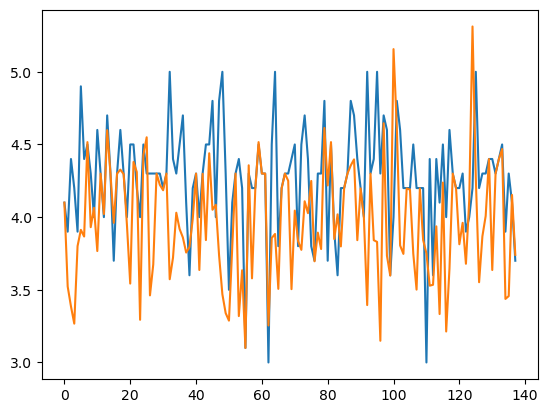

In [156]:
test_plot(train_test['rating'], train_train_pred)